# Introduction to Reservoir Computing and ReservoirPy

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

rpy.verbosity(0)
# Make everything deterministic
rpy.set_seed(2341)

## A simple example: Mackey-Glass

#### Importing the chaotic timeseries Mackey-Glass

In [2]:
from reservoirpy.datasets import mackey_glass

timeseries = mackey_glass(n_timesteps=2_000)
timeseries.shape

(2000, 1)

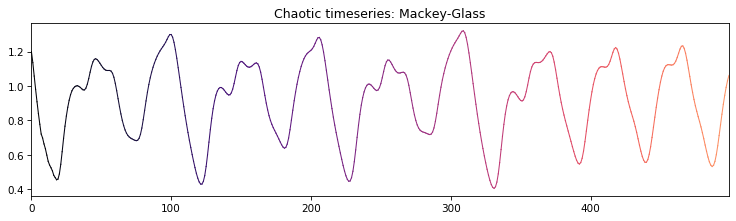

In [3]:
X = timeseries
timesteps = 500
plt.figure(figsize=(12, 3))
for i in range(timesteps-1):
    plt.plot([i, i+1], X[i:i+2, 0], color=plt.cm.magma(200*i//timesteps), lw=1.0)
plt.title("Chaotic timeseries: Mackey-Glass")
plt.show()

#### Data pre-processing

X/Y and train/test split

In [4]:
from reservoirpy.datasets import to_forecasting

dataset = to_forecasting(X, forecast=10, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

In [5]:
print(
    x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape,
)

(1590, 1) (400, 1) (1590, 1) (400, 1)


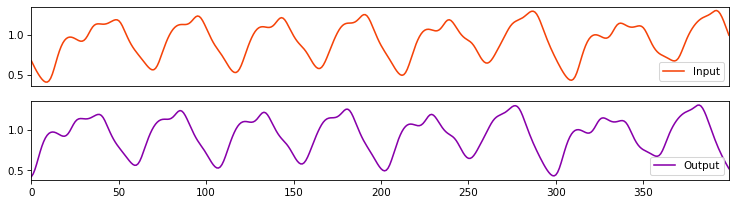

In [6]:
plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test, label="Input")
plt.legend()
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, label="Output", color="#8800AA")
plt.legend()
plt.show()

#### Model creation

In [ ]:
from reservoirpy.nodes import ESN

In [7]:
model = ESN(
    units=100, # neurons inside the reservoir
    lr=0.3, # leak rate
    sr=1.25, # spectral radius of the weight matrix
    ridge=1e-8) # Regularization parameter

In [8]:
reservoir = Reservoir(
    units=100, # neurons inside the reservoir
    lr=0.3, # leak rate
    sr=1.25, # spectral radius of the weight matrix
)
readout = Ridge(ridge=1e-8) # Regularized linear layer
model = reservoir >> readout # Connecting the nodes

#### Fitting and running

In [9]:
model.fit(x_train, y_train) # Learning phase
y_pred = model.run(x_test) # Prediction

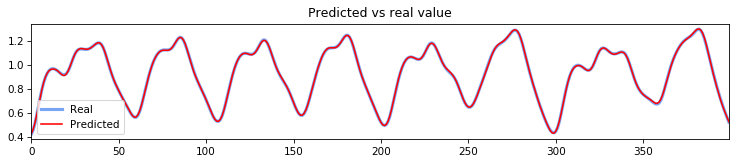

In [10]:
plt.figure(figsize=(12,2))
plt.plot(1)
plt.plot(y_test, label="Real", linewidth=3)
plt.plot(y_pred, label="Predicted", color="red")
plt.title("Predicted vs real value")
plt.legend()
plt.show()

### What about a $t+50$ prediction ?

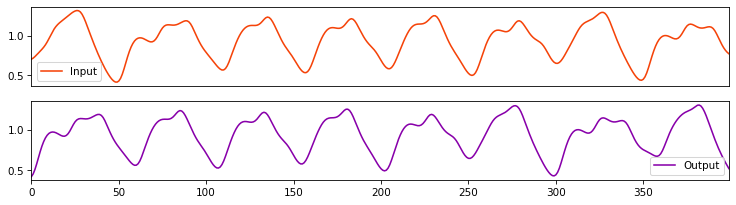

In [11]:
dataset = to_forecasting(X, forecast=50, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test, label="Input")
plt.legend()
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, label="Output", color="#8800AA")
plt.legend()
plt.show()

In [12]:
# Model creation
reservoir = Reservoir(units=100, lr=0.3, sr=1.25,)
readout = Ridge(ridge=1e-8) 
model = reservoir >> readout

# Fitting the model
model.fit(x_train, y_train)
# Testing the model
y_pred = model.run(x_test)

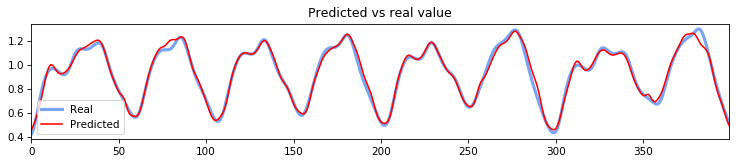

In [13]:
plt.figure(figsize=(12,2))
plt.plot(1)
plt.plot(y_test, label="Real", linewidth=3)
plt.plot(y_pred, label="Predicted", color="red")
plt.title("Predicted vs real value")
plt.legend()
plt.show()

### Summary

In [20]:
model = ESN(
    units=100, # neurons inside the reservoir
    lr=0.3, # leak rate
    sr=1.25, # spectral radius of the weight matrix
    ridge=1e-8, # Regularization parameter
)

# Fitting the model
model.fit(x_train, y_train)
# Testing the model
y_pred = model.run(x_test)

### Listening to the reservoir's heart

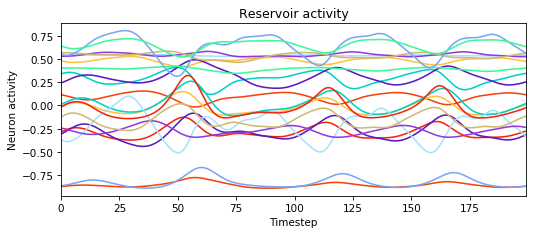

In [14]:
activity = reservoir.run(x_test)

plt.figure(figsize=(8, 3))
plt.plot(activity[:200, :20]) # 200 timestep, 20 neurons
plt.title("Reservoir activity")
plt.xlabel("Timestep")
plt.ylabel("Neuron activity")
plt.show()

### Simple forward connection

In [15]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=10)
readout = Ridge(ridge=1e-4)

model = reservoir >> readout

### Feedback connections

In [16]:
reservoir = Reservoir(units=10)
readout = Ridge(ridge=1e-4)

reservoir <<= readout # create feedback
model = reservoir >> readout

### `scikit-learn` node

In [17]:
from reservoirpy.nodes import ScikitLearnNode
from sklearn.linear_model import (
    RidgeClassifier, 
    LogisticRegression,
)
reservoir = Reservoir(units=10)

classifier = ScikitLearnNode(RidgeClassifier)
logistic_regressor = ScikitLearnNode(LogisticRegression)

model1 = reservoir >> classifier
model2 = reservoir >> logistic_regressor

### Creating custom nodes

In [18]:
from reservoirpy import Node

def forward(node: Node, x: np.ndarray) -> np.ndarray:
    """Does something to the current state of the node, the input
    data and some feedback."""

    state = node.state()  # get current node state
    some_param = node.const1
    some_other_param = node.const2
    if node.has_feedback:
        feedback = node.feedback()  # call state of some distant node
        return x + some_param * state + some_other_param * feedback
    else:
        return x + some_param * state

def initialize(node: Node, x: np.ndarray = None, y: np.ndarray = None):
    """This function receives a data point x at runtime and uses it to
    infer input and output dimensions.
    """
    if x is not None:
        node.set_input_dim(x.shape[1])
        node.set_output_dim(x.shape[1])
        node.set_param("const1", 1)

class CustomNode(Node):
    def __init__(self, const2=-1, name=None):
        super().__init__(
            forward=forward,
            initializer=initialize,
            params={"const1": None},
            hypers={"const2": const2},
            name=name,
        )

node = CustomNode(const2=-1, name="custom_node")

### Create complex architectures

In [19]:
from reservoirpy.nodes import Input, Output

A, B, C, D, E, F = (Node() for _ in range(6))

path1, path2 = A >> F, B >> E
# One-to-many connection using a list
path3 = Input() >> [A, B, C]
# Chain of connections
path4 = A >> B >> C >> D >> E >> F >> Output()
# Merge all pathways to create the full computational graph
model = path1 & path2 & path3 & path4